In [1]:
import os
import math
import time
import copy
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from transformers import RobertaModel, RobertaTokenizerFast
from transformers import get_scheduler
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!gdown "https://drive.google.com/uc?id=1bMEvT38rTLBtj6qBhE8UKDGVY20QkPy4"

Downloading...
From (original): https://drive.google.com/uc?id=1bMEvT38rTLBtj6qBhE8UKDGVY20QkPy4
From (redirected): https://drive.google.com/uc?id=1bMEvT38rTLBtj6qBhE8UKDGVY20QkPy4&confirm=t&uuid=352558cc-32b2-418b-81ac-fe0575799ed0
To: /content/hateful_memes.zip
100% 3.60G/3.60G [00:52<00:00, 68.0MB/s]


In [3]:
!unzip "hateful_memes.zip" -d .

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: ./data/img/49758.png    
  inflating: ./data/img/49762.png    
  inflating: ./data/img/49785.png    
  inflating: ./data/img/49786.png    
  inflating: ./data/img/49802.png    
  inflating: ./data/img/49805.png    
  inflating: ./data/img/49806.png    
  inflating: ./data/img/49807.png    
  inflating: ./data/img/49810.png    
  inflating: ./data/img/49826.png    
  inflating: ./data/img/49831.png    
  inflating: ./data/img/49832.png    
  inflating: ./data/img/49836.png    
  inflating: ./data/img/49850.png    
  inflating: ./data/img/49856.png    
  inflating: ./data/img/49861.png    
  inflating: ./data/img/49863.png    
  inflating: ./data/img/49867.png    
  inflating: ./data/img/49870.png    
  inflating: ./data/img/50124.png    
  inflating: ./data/img/50126.png    
  inflating: ./data/img/50129.png    
  inflating: ./data/img/50137.png    
  inflating: ./data/img/50142.png    
  inflating: ./data/img/50146.png    
  inflating: ./data/img

In [4]:
def merge_jsonl_files(input_files, output_file):
    dfs = []

    for input_file in input_files:
        df = pd.read_json(input_file, lines=True)
        dfs.append(df)

    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_json(output_file, orient='records', lines=True)

    print(f"Merged {len(input_files)} JSONL files into '{output_file}'")


input_files = ['llava_output1.jsonl', 'llava_output2.jsonl']
output_file = 'llava_output.jsonl'

# Merge the input files into the output file using pandas
merge_jsonl_files(input_files, output_file)

Merged 2 JSONL files into 'llava_output.jsonl'


In [5]:
meme_cap = pd.read_json('llava_output.jsonl', lines=True)

# Print some basic information of the dataset
print("Attributes and data types:")
print(meme_cap.dtypes)

print("-" * 30)
print(f"Size of dataset: {len(meme_cap)}")

Attributes and data types:
question_id     int64
prompt         object
text           object
answer_id      object
model_id       object
category        int64
metadata       object
dtype: object
------------------------------
Size of dataset: 8500


In [6]:
data = pd.read_json('data/train.jsonl', lines=True)
data = data[['id', 'text']]
data = data.rename(columns={'text': 'meme_text'})

meme_cap = meme_cap[['question_id', 'text', 'category']]
meme_cap = meme_cap.rename(columns={'question_id': 'id'})
meme_cap = meme_cap.rename(columns={'text': 'meme_cap'})

aug_data = pd.merge(meme_cap, data, on='id', how='inner')

### Hyperparameters

In [7]:
seed = 4995
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

max_len = 128

batch_size = 16
hidden_size = 768

criterion = nn.CrossEntropyLoss()
learning_rate = 2e-6
num_epochs = 15
num_warmup_steps = 500

### Dataset and DataLoaders

In [8]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [9]:
class AugHatefulMemesDataset(Dataset):
    def __init__(self, tokenizer, aug_data, max_len=128, use_meme_text=True):
        self.tokenizer = tokenizer
        self.data = aug_data

        self.max_len = max_len
        self.use_meme_text = use_meme_text

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        try:
            item = self.data.iloc[index]
            meme_cap = item['meme_cap']

            if self.use_meme_text:
                meme_text = item['meme_text']
                sentences = [meme_text, meme_cap]
                merged_sentence = ". ".join(sentences)

                inputs = self.tokenizer.encode_plus(
                    merged_sentence,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
            else:
                inputs = self.tokenizer.encode_plus(
                    meme_cap,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
            tokens = inputs['input_ids']
            mask = inputs['attention_mask']

            return {
                'id': item['id'],
                'tokens': tokens,
                'mask': mask,
                'targets': item['category']
            }
        except Exception as exc:
            return None

In [10]:
def collate_fn(batch):
    # Filter data that fails to load
    batch = list(filter(lambda x: x is not None, batch))

    # Collate into mini-batches
    ids = torch.LongTensor([b['id'] for b in batch])
    texts = torch.cat([b['tokens'] for b in batch], dim=0)
    masks = torch.cat([b['mask'] for b in batch], dim=0)
    labels = torch.LongTensor([b['targets'] for b in batch])

    return ids, texts, masks, labels

In [11]:
dataset_cap_n_txt = AugHatefulMemesDataset(tokenizer, aug_data, use_meme_text=True)
dataset_cap_only = AugHatefulMemesDataset(tokenizer, aug_data, use_meme_text=False)

indices = np.arange(len(dataset_cap_only))
np.random.shuffle(indices)

val_size = 1500

train_indices = indices[val_size:]
val_indices = indices[:val_size]

train_subset_cap_n_txt = Subset(dataset_cap_n_txt, train_indices)
val_subset_cap_n_txt = Subset(dataset_cap_n_txt, val_indices)

train_subset_cap_only = Subset(dataset_cap_only, train_indices)
val_subset_cap_only = Subset(dataset_cap_only, val_indices)

dataloaders_cap_n_txt = {
    'train': DataLoader(train_subset_cap_n_txt, batch_size=batch_size, shuffle=True,
                        collate_fn=collate_fn, num_workers=0),
    'val': DataLoader(val_subset_cap_n_txt, batch_size=batch_size, shuffle=False,
                      collate_fn=collate_fn, num_workers=0)
    }

dataloaders_cap_only = {
    'train': DataLoader(train_subset_cap_only, batch_size=batch_size, shuffle=True,
                        collate_fn=collate_fn, num_workers=0),
    'val': DataLoader(val_subset_cap_only, batch_size=batch_size, shuffle=False,
                      collate_fn=collate_fn, num_workers=0)
    }

dataset_sizes = {'train': len(train_indices), 'val': len(val_indices)}

### Model

In [12]:
lm = RobertaModel.from_pretrained("roberta-base")
lm.pooler = None

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
class HatefulCls(nn.Module):
    def __init__(self, lm, hidden_size):
        super(HatefulCls, self).__init__()
        self.lm = lm
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 2)
            )

    def forward(self, input_ids, attention_mask):
        outputs = self.lm(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs[0]
        pooler = hidden_states[:, 0]
        logits = self.classifier(pooler)
        return logits

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HatefulCls(lm, hidden_size)
model.to(device)

HatefulCls(
  (lm): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((76

### Train

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for step, batch in enumerate(dataloaders[phase]):
                _, texts, masks, labels = batch
                texts = texts.to(device)
                masks = masks.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(texts, masks)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * texts.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=len(dataloaders_cap_n_txt['train']) * num_epochs
    )

model = train_model(model, dataloaders_cap_n_txt, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 1/15
--------------------
train Loss: 0.6777 Acc: 0.5557
val Loss: 0.6401 Acc: 0.6440

Epoch 2/15
--------------------
train Loss: 0.6221 Acc: 0.6593
val Loss: 0.5903 Acc: 0.7107

Epoch 3/15
--------------------
train Loss: 0.5563 Acc: 0.7276
val Loss: 0.5483 Acc: 0.7327

Epoch 4/15
--------------------
train Loss: 0.5100 Acc: 0.7589
val Loss: 0.5368 Acc: 0.7373

Epoch 5/15
--------------------
train Loss: 0.4781 Acc: 0.7773
val Loss: 0.5296 Acc: 0.7447

Epoch 6/15
--------------------
train Loss: 0.4484 Acc: 0.7954
val Loss: 0.5433 Acc: 0.7407

Epoch 7/15
--------------------
train Loss: 0.4196 Acc: 0.8160
val Loss: 0.5588 Acc: 0.7447

Epoch 8/15
--------------------
train Loss: 0.4015 Acc: 0.8227
val Loss: 0.5637 Acc: 0.7433

Epoch 9/15
--------------------
train Loss: 0.3807 Acc: 0.8369
val Loss: 0.5889 Acc: 0.7340

Epoch 10/15
--------------------
train Loss: 0.3632 Acc: 0.8446
val Loss: 0.5991 Acc: 0.7380

Epoch 11/15
--------------------
train Loss: 0.3436 Acc: 0.8580
val L

In [ ]:
dir = 'drive/MyDrive/hateful_memes'
path = os.path.join(dir, 'model_cls_full.pth')

torch.save(model.state_dict(), path)

With another data config

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=len(dataloaders_cap_only['train']) * num_epochs
    )

model = train_model(model, dataloaders_cap_only, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 1/15
--------------------
train Loss: 0.6887 Acc: 0.5171
val Loss: 0.6457 Acc: 0.6440

Epoch 2/15
--------------------
train Loss: 0.6290 Acc: 0.6556
val Loss: 0.6110 Acc: 0.6833

Epoch 3/15
--------------------
train Loss: 0.5929 Acc: 0.6973
val Loss: 0.6028 Acc: 0.6933

Epoch 4/15
--------------------
train Loss: 0.5669 Acc: 0.7184
val Loss: 0.5865 Acc: 0.6960

Epoch 5/15
--------------------
train Loss: 0.5492 Acc: 0.7336
val Loss: 0.5886 Acc: 0.6973

Epoch 6/15
--------------------
train Loss: 0.5275 Acc: 0.7470
val Loss: 0.5929 Acc: 0.7020

Epoch 7/15
--------------------
train Loss: 0.5012 Acc: 0.7690
val Loss: 0.6044 Acc: 0.6993

Epoch 8/15
--------------------
train Loss: 0.4857 Acc: 0.7809
val Loss: 0.6060 Acc: 0.6960

Epoch 9/15
--------------------
train Loss: 0.4684 Acc: 0.7920
val Loss: 0.6268 Acc: 0.7047

Epoch 10/15
--------------------
train Loss: 0.4481 Acc: 0.8041
val Loss: 0.6324 Acc: 0.7027

Epoch 11/15
--------------------
train Loss: 0.4339 Acc: 0.8099
val L

In [ ]:
path = os.path.join(dir, 'model_cls_full_cap_only.pth')

torch.save(model.state_dict(), path)

In [ ]:
learning_rate = 1e-6

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=len(dataloaders_cap_only['train']) * num_epochs
    )

model = train_model(model, dataloaders_cap_only, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 1/15
--------------------
train Loss: 0.6873 Acc: 0.5376
val Loss: 0.6542 Acc: 0.6440

Epoch 2/15
--------------------
train Loss: 0.6469 Acc: 0.6411
val Loss: 0.6249 Acc: 0.6440

Epoch 3/15
--------------------
train Loss: 0.6212 Acc: 0.6589
val Loss: 0.6043 Acc: 0.6800

Epoch 4/15
--------------------
train Loss: 0.5973 Acc: 0.6946
val Loss: 0.5947 Acc: 0.6980

Epoch 5/15
--------------------
train Loss: 0.5819 Acc: 0.7120
val Loss: 0.6076 Acc: 0.6880

Epoch 6/15
--------------------
train Loss: 0.5660 Acc: 0.7219
val Loss: 0.5941 Acc: 0.6987

Epoch 7/15
--------------------
train Loss: 0.5533 Acc: 0.7286
val Loss: 0.5914 Acc: 0.6967

Epoch 8/15
--------------------
train Loss: 0.5456 Acc: 0.7347
val Loss: 0.5928 Acc: 0.6967

Epoch 9/15
--------------------
train Loss: 0.5367 Acc: 0.7443
val Loss: 0.5899 Acc: 0.7040

Epoch 10/15
--------------------
train Loss: 0.5272 Acc: 0.7487
val Loss: 0.5926 Acc: 0.7047

Epoch 11/15
--------------------
train Loss: 0.5216 Acc: 0.7527
val L

In [ ]:
path = os.path.join(dir, 'model_cls_full_cap_only_1.pth')

torch.save(model.state_dict(), path)

### Another model

In [14]:
class HatefulAvgPool(nn.Module):
    def __init__(self, lm, hidden_size):
        super(HatefulAvgPool, self).__init__()
        self.lm = lm
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 2)
            )

    def forward(self, input_ids, attention_mask):
        outputs = self.lm(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs[0]
        avg_pool = torch.mean(hidden_states, dim=1)
        logits = self.classifier(avg_pool)
        return logits

In [ ]:
model = HatefulAvgPool(lm, hidden_size)
model.to(device)

HatefulAvgPool(
  (lm): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=len(dataloaders_cap_n_txt['train']) * num_epochs
    )

model = train_model(model, dataloaders_cap_n_txt, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 1/15
--------------------
train Loss: 0.6635 Acc: 0.6126
val Loss: 0.6355 Acc: 0.6440

Epoch 2/15
--------------------
train Loss: 0.5876 Acc: 0.6916
val Loss: 0.5600 Acc: 0.7213

Epoch 3/15
--------------------
train Loss: 0.5211 Acc: 0.7499
val Loss: 0.5399 Acc: 0.7373

Epoch 4/15
--------------------
train Loss: 0.4792 Acc: 0.7806
val Loss: 0.5392 Acc: 0.7387

Epoch 5/15
--------------------
train Loss: 0.4476 Acc: 0.7947
val Loss: 0.5383 Acc: 0.7427

Epoch 6/15
--------------------
train Loss: 0.4205 Acc: 0.8146
val Loss: 0.5472 Acc: 0.7380

Epoch 7/15
--------------------
train Loss: 0.3882 Acc: 0.8337
val Loss: 0.5910 Acc: 0.7327

Epoch 8/15
--------------------
train Loss: 0.3687 Acc: 0.8446
val Loss: 0.5858 Acc: 0.7407

Epoch 9/15
--------------------
train Loss: 0.3483 Acc: 0.8549
val Loss: 0.6080 Acc: 0.7213

Epoch 10/15
--------------------
train Loss: 0.3262 Acc: 0.8679
val Loss: 0.6179 Acc: 0.7387

Epoch 11/15
--------------------
train Loss: 0.3132 Acc: 0.8739
val L

In [ ]:
path = os.path.join(dir, 'model_avg_pool_full.pth')

torch.save(model.state_dict(), path)

With another data config (meme caption only)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=len(dataloaders_cap_only['train']) * num_epochs
    )

model = train_model(model, dataloaders_cap_only, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 1/15
--------------------
train Loss: 0.6763 Acc: 0.5539
val Loss: 0.6187 Acc: 0.6487

Epoch 2/15
--------------------
train Loss: 0.6006 Acc: 0.6914
val Loss: 0.5889 Acc: 0.6940

Epoch 3/15
--------------------
train Loss: 0.5646 Acc: 0.7227
val Loss: 0.5910 Acc: 0.6920

Epoch 4/15
--------------------
train Loss: 0.5406 Acc: 0.7393
val Loss: 0.5851 Acc: 0.7087

Epoch 5/15
--------------------
train Loss: 0.5159 Acc: 0.7591
val Loss: 0.5931 Acc: 0.7060

Epoch 6/15
--------------------
train Loss: 0.4861 Acc: 0.7800
val Loss: 0.6073 Acc: 0.7013

Epoch 7/15
--------------------
train Loss: 0.4664 Acc: 0.7877
val Loss: 0.6124 Acc: 0.6993

Epoch 8/15
--------------------
train Loss: 0.4407 Acc: 0.8069
val Loss: 0.6245 Acc: 0.6947

Epoch 9/15
--------------------
train Loss: 0.4234 Acc: 0.8099
val Loss: 0.6476 Acc: 0.6973

Epoch 10/15
--------------------
train Loss: 0.4025 Acc: 0.8280
val Loss: 0.6469 Acc: 0.6940

Epoch 11/15
--------------------
train Loss: 0.3839 Acc: 0.8347
val L

In [ ]:
path = os.path.join(dir, 'model_avg_pool_full_cap_only.pth')

torch.save(model.state_dict(), path)

### Evaluation

In [15]:
def evaluate_model(model, dataloader):
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            _, texts, masks, labels = batch
            texts = texts.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            outputs = model(texts, masks)
            _, predicted = torch.max(outputs, dim=1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    auroc = roc_auc_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)

    return accuracy, precision, recall, f1, auroc, cm

In [19]:
dir = 'drive/MyDrive/hateful_memes'
path = os.path.join(dir, 'model_cls_full.pth')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = HatefulCls(lm, hidden_size)
model.load_state_dict(torch.load(path))
model.to(device)

accuracy, precision, recall, f1, auroc, cm = evaluate_model(model, dataloaders_cap_n_txt['val'])
print("Model using cls tokens only:")
print("Evaluate on meme text and meme caption:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUROC Score: {auroc:.4f}")
print(cm)


accuracy, precision, recall, f1, auroc, cm_1 = evaluate_model(model, dataloaders_cap_only['val'])
print("-" * 20)
print("Evaluate on meme caption only:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUROC Score: {auroc:.4f}")
print(cm_1)

Model using cls tokens only:
Evaluate on meme text and meme caption:
Accuracy: 0.7447
Precision: 0.6596
Recall: 0.5843
F1 Score: 0.6197
AUROC Score: 0.7088
[[805 161]
 [222 312]]
--------------------
Evaluate on meme caption only:
Accuracy: 0.7013
Precision: 0.6762
Recall: 0.3090
F1 Score: 0.4242
AUROC Score: 0.6136
[[887  79]
 [369 165]]


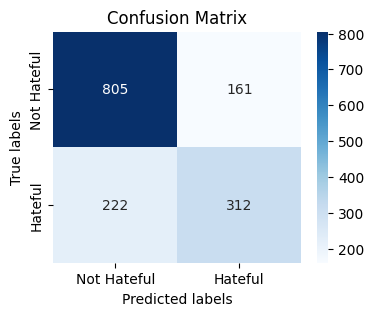

In [22]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Hateful', 'Hateful'],
            yticklabels=['Not Hateful', 'Hateful'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
path = os.path.join(dir, 'model_avg_pool_full.pth')

model = HatefulAvgPool(lm, hidden_size)
model.load_state_dict(torch.load(path))
model.to(device)

accuracy, precision, recall, f1, auroc = evaluate_model(model, dataloaders_cap_n_txt['val'])
print("Model using average pooled feature of all tokens:")
print("Evaluate on meme text and meme caption:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUROC Score: {auroc:.4f}")


accuracy, precision, recall, f1, auroc = evaluate_model(model, dataloaders_cap_only['val'])
print("-" * 20)
print("Evaluate on meme caption only:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUROC Score: {auroc:.4f}")

Model using average pooled feature of all tokens:
Evaluate on meme text and meme caption:
Accuracy: 0.7427
Precision: 0.6581
Recall: 0.5768
F1 Score: 0.6148
AUROC Score: 0.7056
--------------------
Evaluate on meme caption only:
Accuracy: 0.6907
Precision: 0.6562
Recall: 0.2753
F1 Score: 0.3879
AUROC Score: 0.5978


In [ ]:
path = os.path.join(dir, 'model_cls_full_cap_only_1.pth')

model = HatefulCls(lm, hidden_size)
model.load_state_dict(torch.load(path))
model.to(device)

accuracy, precision, recall, f1, auroc = evaluate_model(model, dataloaders_cap_only['val'])
print("Model using cls tokens only:")
print("Evaluate on meme caption only:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUROC Score: {auroc:.4f}")


accuracy, precision, recall, f1, auroc = evaluate_model(model, dataloaders_cap_n_txt['val'])
print("-" * 20)
print("Evaluate on meme text and meme caption:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUROC Score: {auroc:.4f}")

Model using cls tokens only:
Evaluate on meme caption only:
Accuracy: 0.7073
Precision: 0.6353
Recall: 0.4176
F1 Score: 0.5040
AUROC Score: 0.6425
--------------------
Evaluate on meme text and meme caption:
Accuracy: 0.7340
Precision: 0.6538
Recall: 0.5375
F1 Score: 0.5899
AUROC Score: 0.6901


In [ ]:
path = os.path.join(dir, 'model_avg_pool_full_cap_only.pth')

model = HatefulAvgPool(lm, hidden_size)
model.load_state_dict(torch.load(path))
model.to(device)

accuracy, precision, recall, f1, auroc = evaluate_model(model, dataloaders_cap_only['val'])
print("Model using average pooled feature of all tokens:")
print("Evaluate on meme caption only:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUROC Score: {auroc:.4f}")


accuracy, precision, recall, f1, auroc = evaluate_model(model, dataloaders_cap_n_txt['val'])
print("-" * 20)
print("Evaluate on meme text and meme caption:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUROC Score: {auroc:.4f}")

Model using average pooled feature of all tokens:
Evaluate on meme caption only:
Accuracy: 0.7087
Precision: 0.6222
Recall: 0.4625
F1 Score: 0.5306
AUROC Score: 0.6536
--------------------
Evaluate on meme text and meme caption:
Accuracy: 0.7353
Precision: 0.6373
Recall: 0.5955
F1 Score: 0.6157
AUROC Score: 0.7041
